In [2]:
CUTOFF = 10

In [67]:
import csv
from tqdm import tqdm

# Initialize an empty list to store the records
parsed_records = []

# Open and read the CSV file
with open('data/KDD19/anno_querysatisfaction.csv', 'r', encoding='utf-8') as csvfile:
    csvreader = csv.DictReader(csvfile)
    
    # Loop through each row in the CSV
    for row in tqdm(csvreader, desc="Processing", unit="rows"):
        # Create a dictionary for each record
        record = {
            'id': row['id'],
            'studentID': row['studentID'],
            'task_id': row['task_id'],
            'query': row['query'],
            'score': row['score']
        }
        # Append the record dictionary to the list
        parsed_records.append(record)

# Show first 5 records for verification
print(len(parsed_records))
print(parsed_records[:5])

Processing: 1548rows [00:00, 96339.23rows/s]

1548
[{'id': '5', 'studentID': '2014012759', 'task_id': '11', 'query': ' 清华游泳馆', 'score': '5'}, {'id': '6', 'studentID': '2014012759', 'task_id': '4', 'query': ' 行李托运 国际航班', 'score': '3'}, {'id': '7', 'studentID': '2014012759', 'task_id': '4', 'query': ' 行李托运 国际航班 美国', 'score': '2'}, {'id': '8', 'studentID': '2014012759', 'task_id': '4', 'query': ' 行李托运 国际航班', 'score': '3'}, {'id': '9', 'studentID': '2014012759', 'task_id': '1', 'query': ' 破冰游戏 十人', 'score': '5'}]


In [68]:
# Initialize an empty dictionary to store the inverted index
inverted_index = {}

# Loop through each parsed record to populate the inverted index
for record in tqdm(parsed_records, desc="Processing", unit="records"):
    query = record['query']
    task_id = record['task_id']
    
    # Check if the query is already in the inverted index
    if query in inverted_index:
        # If the task_id is not already in the list for this query, append it
        if task_id not in inverted_index[query]:
            inverted_index[query].append(task_id)
    else:
        # If the query is not in the inverted index, add it with the task_id as the first element in the list
        inverted_index[query] = [task_id]

# For clarity, ensure each query only maps to unique task_ids
for query, task_ids in inverted_index.items():
    inverted_index[query] = list(set(task_ids))
    if len(inverted_index[query]) > 1:
        print(f"Multiple tasks query found: {query}. Tasks: {', '.join(inverted_index[query])}")

Processing: 100%|██████████████████| 1548/1548 [00:00<00:00, 182586.69records/s]

Multiple tasks query found:  北京周边 旅游. Tasks: 2, 3
Multiple tasks query found: 清华大学. Tasks: 11, 3
Multiple tasks query found: 京东. Tasks: 10, 3
Multiple tasks query found: 淘宝. Tasks: 8, 3


In [75]:
# Unique queries in user records
query_codebook = {query: str(i+1) for i, query in enumerate(inverted_index.keys())}

# sample
print(len(query_codebook))
print(dict(list(query_codebook.items())[:5]))

1092
{' 清华游泳馆': '1', ' 行李托运 国际航班': '2', ' 行李托运 国际航班 美国': '3', ' 破冰游戏 十人': '4', ' 戒烟': '5'}


In [71]:
doc_topic_map = {}
doc_text_map = {}

import csv
from tqdm import tqdm
from bs4 import BeautifulSoup

# Define a function to extract text from the HTML content
def extract_text_from_html(html_content):
    soup = BeautifulSoup(html_content, 'html.parser')
    
    # Remove content within <div class="r-sech ext_query">
    for div in soup.find_all("div", class_="r-sech ext_query"):
        div.decompose()
    
    # Extract text from the parsed HTML
    extracted_text = soup.get_text()
    
    # Remove unwanted trailing text
    unwanted_text = '翻译此页 \xa0-\xa0快照\xa0-\xa0预览'
    if unwanted_text in extracted_text:
        extracted_text = extracted_text.replace(unwanted_text, "")
        
    return extracted_text.strip()

exception_query = []

with open('data/KDD19/anno_searchresult.csv', 'r', encoding='utf-8') as csvfile:
    csvreader = csv.DictReader(csvfile)
    
    for row in tqdm(csvreader, desc="Processing", unit="rows"):
        query = row['query']
        if query not in query_codebook:
            if query not in exception_query:
                exception_query.append(query)
            continue
        rank = row['rank']
        docno = query_codebook[query] + '_' + rank
        
        # Extract text from the HTML content
        content_text = extract_text_from_html(row["content"])
        doc_text_map[docno] = content_text
        # Check if query exists in invert_index, if not assign it to a dummy topic
        topic = inverted_index.get(query, ['unknown_topic'])
        
        doc_topic_map[docno] = topic

Processing: 18389rows [00:33, 551.00rows/s] 


In [73]:
print(len(exception_query))

100


In [79]:
# sample
print(len(doc_topic_map))
print(dict(list(doc_topic_map.items())[:5]))
print(dict(list(doc_text_map.items())[:5]))

16870
{'728_0': ['7'], '728_1': ['7'], '728_2': ['7'], '728_3': ['7'], '728_4': ['7']}
{'728_0': '看看戒烟的十大好处   首先要下定决心知道戒烟的好处有哪些，那么接下来就和天天营养的编编一起先来看看戒烟的好处吧！ 1，延缓皮肤衰老 停止吸烟能延缓面部衰老，延迟皱纹出现。不吸烟者的皮肤...  www.jieyanri.com/ji...\xa0-\xa02016-12-29', '728_1': '戒烟的好处 - 三九养生堂   今天小编就给大家介绍一下如何戒烟、戒烟的好处以及戒烟后的症状，刚兴趣的小伙伴 医院戒烟门诊已64天无人就诊沈阳男性吸烟率44.7%，戒烟门诊患者却不多2015年12月28日...  三九养生堂 - www.39yst.com/flist...\xa0-\xa02017-11-30', '728_2': '戒烟的好处有哪些_亲子百科_太平洋亲子网   （二）戒烟后的远期好处 1、患癌的危险性减少 戒烟5-10年后，其肺癌死亡率比不吸烟者略为高一点，戒烟10-15后，得肺癌的机会便可降低到与不吸烟一样。据日本调查，吸烟总...  baike.pcbaby.com.cn...\xa0-\xa02017-11-29', '728_3': '戒烟的好处非常多 - 好大夫在线   2014年3月7日 - 戒烟的好处非常多： 1）戒烟一天， 戒烟给心脏、血压和血液系统带来的益处便会显现出来 。 2）戒烟1年，冠心病的超额危险性比继续吸烟者下降一半 。 3）戒...  好大夫在线 - www.haodf.com/zhuan...\xa0-\xa02014-3-7', '728_4': '看看戒烟后不同时间段的好处   1.戒烟后20分钟心率开始恢复正常 戒烟的健康益处立即就会显现出来。距离你吸完最后一支香烟20分钟，你的心率就渐渐开始向正常水平恢复。 2.戒烟后两小时外周循环得到改善 ...  www.jieyanri.com/ji...\xa0-\xa02015-6-9'}


In [77]:
# topic-doc
topic_doc_map = {}
for docno, topics in doc_topic_map.items():
    for topic in topics:
        if topic not in topic_doc_map:
            topic_doc_map[topic] = []
        topic_doc_map[topic].append(docno)

In [83]:
# sample
print(len(topic_doc_map))
#print(dict(list(topic_doc_map.items())[:1]))

9


# Utility Functions to Compute Sentence Similarity

In [84]:
from Levenshtein import distance, ratio
import jieba
from collections import Counter
from math import sqrt

SW_PATH = 'utils/stop_words.txt'
SW_LIST = [k.strip() for k in open(SW_PATH, encoding='utf8').readlines() if k.strip() != '']

# Get Stopword List
def get_tl_no_sw(input_sentence):
    token_list = jieba.cut(input_sentence)
    return list(filter(lambda x: not(x == ' ' or (len(x) == 1 and x in SW_LIST)), token_list))


In [85]:
# Solution 1
# Levenshtein normalized similarity

def get_lev_sim(list1, list2):
    return ratio(''.join(sl_no_sw_1), ''.join(sl_no_sw_2))

# Solution 2
# Cosine Similarity

def get_cos_sim(list1, list2):
    # Step 1: Create a vocabulary
    vocab = set(list1) | set(list2)
    
    # Step 2: Create word frequency vectors
    vec1 = Counter(list1)
    vec2 = Counter(list2)
    
    # Step 3: Calculate cosine similarity
    intersection = set(vec1.keys()) & set(vec2.keys())
    numerator = sum([vec1[x] * vec2[x] for x in intersection])

    sum1 = sum([vec1[x]**2 for x in vec1.keys()])
    sum2 = sum([vec2[x]**2 for x in vec2.keys()])
    denominator = sqrt(sum1) * sqrt(sum2)

    if not denominator:
        return 0.0
    else:
        return float(numerator) / denominator


In [86]:
# Define a placeholder get_sim function for demonstration purpose
def get_sim(tl_1, tl_2):
    return get_cos_sim(tl_1, tl_2)

In [87]:
from tqdm import tqdm

for k, v in tqdm(doc_text_map.items(), desc="Processing", unit="docs"):
    doc_text_map[k] = get_tl_no_sw(v)

Processing: 100%|█████████████████████| 16870/16870 [00:10<00:00, 1620.57docs/s]


In [88]:
import json
# VERY time consuming
def get_similarity_pair():
    similarity_scores = {}
    # For each topic, compare each document with every other document in the same topic
    for topic, documents in topic_doc_map.items():
        print("Currently processing: " + topic)
        for doc_id1 in tqdm(documents, desc="Processing topics"):
            for doc_id2 in documents:
                # Ensure doc_id1 is smaller than doc_id2
                if doc_id1 >= doc_id2:
                    continue
                # Calculate similarity
                similarity = get_sim(doc_text_map[doc_id1], doc_text_map[doc_id2])
                # Store in the dictionary
                if doc_id1 not in similarity_scores:
                    similarity_scores[doc_id1] = {}
                similarity_scores[doc_id1][doc_id2] =  round(similarity, 3)

    # Save the similarity scores to a JSON file
    OUTPUT_FILE = "output/similarity_scores_kdd.json"
    with open(OUTPUT_FILE, 'w') as f:
        json.dump(similarity_scores, f)

In [89]:
#get_similarity_pair()
# or read json file directly
#with open('output/similarity_scores_kdd.json', 'r', encoding='utf-8') as file:
#    similarity_scores = json.load(file)

Currently processing: 7


Processing topics: 100%|██████████████████████| 841/841 [00:13<00:00, 64.44it/s]


Currently processing: 11


Processing topics: 100%|████████████████████| 1948/1948 [01:13<00:00, 26.40it/s]


Currently processing: 4


Processing topics: 100%|████████████████████| 2611/2611 [02:13<00:00, 19.57it/s]


Currently processing: 1


Processing topics: 100%|████████████████████| 1187/1187 [00:28<00:00, 41.31it/s]


Currently processing: 10


Processing topics: 100%|████████████████████| 2153/2153 [01:35<00:00, 22.60it/s]


Currently processing: 8


Processing topics: 100%|██████████████████████| 825/825 [00:13<00:00, 61.87it/s]


Currently processing: 2


Processing topics: 100%|████████████████████| 2660/2660 [02:18<00:00, 19.25it/s]


Currently processing: 3


Processing topics: 100%|████████████████████| 3163/3163 [03:03<00:00, 17.28it/s]


Currently processing: 12


Processing topics: 100%|████████████████████| 1551/1551 [00:46<00:00, 33.08it/s]


In [91]:
import os
if not os.path.exists('output/similarity_scores_kdd.json'):
    get_similarity_pair()
    
# Read JSON file directly
with open('output/similarity_scores_kdd.json', 'r', encoding='utf-8') as file:
    similarity_scores = json.load(file)

In [92]:
similarity_pair_list = [(docno1, docno2, score) 
               for docno1, inner_dict in similarity_scores.items() 
               for docno2, score in inner_dict.items()]

print(similarity_pair_list[:5])

[('728_0', '728_1', 0.429), ('728_0', '728_2', 0.434), ('728_0', '728_3', 0.402), ('728_0', '728_4', 0.394), ('728_0', '728_5', 0.412)]


In [106]:
import numpy as np

# Extract the similarity scores
similarity_list = [x[2] for x in similarity_pair_list]

# Function to calculate the xth percentile
def calculate_percentile(scores, x):
    return np.percentile(scores, x)

# Calculate percentiles for 10, 20, 25, 50, 75, 90
percentiles = [80, 90, 95, 99, 99.5, 99.9]
percentile_values = {x: calculate_percentile(similarity_list, x) for x in percentiles}

percentile_values

{80: 0.322, 90: 0.392, 95: 0.456, 99: 0.6, 99.5: 0.678, 99.9: 0.977}

# Utility Functions to Get Document Usefulness & Relevance

## Relevance

In [97]:
# Here is the complete code to read the txt file and process it

# Initialize the result dictionary
doc_task_relevance_map = {}

# Read the file and parse it line by line
with open('data/KDD19/all_relevance_annotation.txt', 'r', encoding='utf-8') as file:
    # Skip the header line (column names)
    file.readline()
    
    # Read each line from the file
    for line in file:
        # Split each line by tab to get individual elements
        task, query, url, rank, query_relevance, task_relevance = line.split('\t')
        
        # Get the query_id from query_codebook
        query_id = query_codebook.get(query, None)
        
        # Skip if query not in query_codebook
        if query_id is None:
            continue
        
        # Create docno
        docno = query_id + '_' + rank.strip()
        
        # Add to the result dictionary
        doc_task_relevance_map[docno] = int(task_relevance.strip())

In [98]:
print(dict(list(doc_task_relevance_map.items())[:5]))

{'345_0': 1, '675_2': 3, '277_1': 3, '111_9': 2, '260_9': 2}


## Usefulness

In [99]:
import csv

# Initialize the result dictionary
record_score_map = {}

# Read the CSV file
with open('data/KDD19/anno_annotation.csv', 'r', encoding='utf-8') as csvfile:
    csvreader = csv.DictReader(csvfile)
    
    # Read each row in the csv
    for row in csvreader:
        # Get necessary fields
        studentID = row['studentID']
        task_id = row['task_id']
        query = row['query']
        result_id = row['result_id'].replace('rb_', '')
        score = row['score']
        
        # Get query_id from query_codebook
        query_id = query_codebook.get(query, None)
        
        # Skip if query not in query_codebook
        if query_id is None:
            continue
        
        # Create record_id
        record_id = f"{studentID}_{task_id}_{query_id}_{result_id}"
        
        # Add to result dictionary
        record_score_map[record_id] = score

# Show a portion of the result
dict(list(record_score_map.items())[:5])

{'2014012759_11_1_0': '4',
 '2014012759_4_2_2': '3',
 '2014012759_4_3_1': '2',
 '2014012759_4_3_7': '1',
 '2014012759_1_4_0': '3'}

# Find Potential Decoy Pairs

In [117]:
SIM_THRESHOLD_DECOY_MIN = calculate_percentile(similarity_list, 99)   # 假设的相似度阈值
SIM_THRESHOLD_DECOY_MAX = 0.95
# Initialize an empty list to store the decoy pairs
decoy_pair = []

# Loop through each record in result_list_grouped_queries
for record in result_list_grouped_queries:
    student_id = record['student_id']
    task_id = record['task_id']
    queries = record['query']
    
    for query_order, query in enumerate(queries):
        query_id = query_codebook.get(query, None)  # Retrieve query_id from query_codebook
        if query_id is None:
            continue  # Skip if query_id is not found
        
        # Generate docnos for the top CUTOFF ranks
        docnos = [f"{query_id}_{rank}" for rank in range(CUTOFF)]
        
        # Loop through each pair of docnos to calculate similarity and relevance
        for i, docno1 in enumerate(docnos):
            for j, docno2 in enumerate(docnos):
                if i >= j:
                    continue  # Skip duplicate pairs
                
                # Retrieve similarity score
                similarity = similarity_scores.get(docno1, {}).get(docno2, 0)  # Handle key not existing
                if similarity == 0:
                    similarity = similarity_scores.get(docno2, {}).get(docno1, 0)  # Reverse key order
                
                # Retrieve relevance score
                rel_doc1 = doc_task_relevance_map.get(docno1, 0)  # Handle key not existing
                rel_doc2 = doc_task_relevance_map.get(docno2, 0)  # Handle key not existing
                
                # Check conditions and append to decoy_pair list
                if SIM_THRESHOLD_DECOY_MIN <= similarity <= SIM_THRESHOLD_DECOY_MAX:
                    if rel_doc1 - rel_doc2 >= 2:
                        decoy_pair.append({
                            'student_id': student_id,
                            'task_id': task_id,
                            'session_num': student_id + '_' + task_id,
                            'interaction_num': str(query_order),
                            'docno_target': docno1,
                            'rank_target': i,
                            'docno_decoy': docno2,
                            'rank_decoy': j
                        })
                    elif rel_doc2 - rel_doc1 >= 2:
                        decoy_pair.append({
                            'student_id': student_id,
                            'task_id': task_id,
                            'session_num': student_id + '_' + task_id,
                            'interaction_num': str(query_order),
                            'docno_target': docno2,
                            'rank_target': j,
                            'docno_decoy': docno1,
                            'rank_decoy': i
                        })

# Show the first few decoy pairs as a sample
print(len(decoy_pair))
print(decoy_pair[:5])

1082
[{'student_id': '1701110210', 'task_id': '10', 'session_num': '1701110210_10', 'interaction_num': '0', 'docno_target': '96_1', 'rank_target': 1, 'docno_decoy': '96_8', 'rank_decoy': 8}, {'student_id': '1701110210', 'task_id': '10', 'session_num': '1701110210_10', 'interaction_num': '5', 'docno_target': '25_1', 'rank_target': 1, 'docno_decoy': '25_9', 'rank_decoy': 9}, {'student_id': '1701110210', 'task_id': '10', 'session_num': '1701110210_10', 'interaction_num': '5', 'docno_target': '25_2', 'rank_target': 2, 'docno_decoy': '25_5', 'rank_decoy': 5}, {'student_id': '1701110210', 'task_id': '10', 'session_num': '1701110210_10', 'interaction_num': '5', 'docno_target': '25_7', 'rank_target': 7, 'docno_decoy': '25_5', 'rank_decoy': 5}, {'student_id': '1701110210', 'task_id': '11', 'session_num': '1701110210_11', 'interaction_num': '2', 'docno_target': '95_6', 'rank_target': 6, 'docno_decoy': '95_5', 'rank_decoy': 5}]


In [115]:
decoy_index = [item['docno_target'] for item in decoy_pair]
print("Decoy Pairs Count: %d"%len(decoy_index))
print("Count of Documents that have at least one decoy: %d"%len(set(decoy_index)))
#print(decoy_index[:5])

Decoy Pairs Count: 1082
Count of Documents that have at least one decoy: 458


# Find Control Documents

In [143]:
relevance_data = doc_task_relevance_map
# Assuming a threshold for the sake of demonstration
SIM_THRESHOLD_CONTROL = calculate_percentile(similarity_list, 99.5)  
print(SIM_THRESHOLD_CONTROL)
target_doc_list = []
control_doc_list = []

# Processing the data as per given conditions
for docno1, docno2, similarity_score in similarity_pair_list:
    if similarity_score > SIM_THRESHOLD_CONTROL:
        # 检查条件
        rel_doc1 = relevance_data[docno1] if docno1 in relevance_data else 0
        rel_doc2 = relevance_data[docno2] if docno2 in relevance_data else 0
        if abs(rel_doc1 - rel_doc2 <= 2):
            if (docno1 in decoy_index and docno2 not in decoy_index):
                target_doc_list.append(docno1)
                control_doc_list.append(docno2)
            elif (docno2 in decoy_index and docno1 not in decoy_index):
                target_doc_list.append(docno2)
                control_doc_list.append(docno1)

target_doc_set = set(target_doc_list)
print("Count of Target Documents that have at least one Control Document: %d"% len(target_doc_set))
control_doc_set = set(control_doc_list)
print("Count of Control Documents: %d" % len(control_doc_set))

0.678
Count of Target Documents that have at least one Control Document: 424
Count of Control Documents: 2116


In [144]:
list(control_doc_set)[:5]

['837_3', '762_7', '713_9', '162_0', '436_21']

In [133]:
decoy_target_record = []
decoy_decoy_record = []
for item in decoy_pair:
    if item['docno_target'] in target_doc_set:
        target_id = item['session_num'] + '_' + item['docno_target']
        decoy_id =  item['session_num'] + '_' + item['docno_decoy']
        decoy_target_record.append(target_id)
        decoy_decoy_record.append(decoy_id)
    
decoy_target_record = set(decoy_target_record)
decoy_decoy_record = set(decoy_decoy_record)

print("Records of decoy target documents, by impression : %d"%len(decoy_target_record))

Records of decoy target documents, by impression : 770


# Compare User Feedback

In [141]:
FILE_PATH_LOG = 'data/KDD19/anno_log.csv'
# Initialize list to store target_doc_interaction
target_doc_interaction = []

# Initialize variables to keep track of current impression
current_student_id = None
current_task_id = None
current_query = None
impression_docs = set()

# Function to handle exceptions and errors
def handle_exception(e, line_number):
    print(f"Exception encountered: {e} at line {line_number}")

    # Get the total number of lines in the file for tqdm progress bar
total_lines = sum(1 for line in open(FILE_PATH_LOG, 'r', encoding='utf-8')) - 1  # Exclude header

# Function to parse content for time
def parse_time(content):
    time_entry = [entry.split('=')[1] for entry in content.split('\t') if entry.startswith('TIME')]
    return int(time_entry[0]) if time_entry else -1
       
# Read the file and process as per requirements
try:
    with open(FILE_PATH_LOG, 'r', encoding='utf-8') as csvfile:
        csvreader = csv.reader(csvfile)
        header = next(csvreader)  # Skip the header

        for row in tqdm(csvreader, total=total_lines, desc="Processing"):
            try:
                _, _, student_id, task_id, action, query, content = row

                # Skip rows with empty queries or queries not in query_codebook
                if query.strip() == '' or query not in query_codebook:
                    continue

                # Check for new impression
                if current_student_id != student_id or current_task_id != task_id or current_query != query:
                    # Process unclicked docs for last impression if current_query is initialized
                    if current_query:
                        for rank in range(10):
                            docno = f"{query_codebook[current_query]}_{rank}"
                            doc_id = f"{current_student_id}_{current_task_id}_{docno}"
                            if doc_id in decoy_target_record and docno not in impression_docs:
                                target_doc_interaction.append({
                                    'docno': docno,
                                    'rank': rank,
                                    'click': False,
                                    'endtime': -1,
                                    'starttime': -1,
                                    'usefulness': int(record_score_map.get(doc_id, '0'))
                                })

                    # Reset current impression details
                    current_student_id = student_id
                    current_task_id = task_id
                    current_query = query
                    impression_docs = set()

                # Process CLICK actions
                if action == 'CLICK':
                    rank = int(content.split('rank=')[1].split('\t')[0])
                    docno = f"{query_codebook[query]}_{rank}"
                    doc_id = f"{student_id}_{task_id}_{docno}"
                    #print(doc_id)
                    impression_docs.add(docno)

                    if doc_id in decoy_target_record:
                        # Find endtime from next row
                        endtime = -1
                        next_row = next(csvreader, None)
                        if next_row:
                            next_student_id = next_row[2]
                            next_task_id = next_row[3]
                            if next_student_id == student_id and next_task_id == task_id:
                                endtime = parse_time(next_row[6])
                            else:
                                csvreader.line_num -= 1  # Go back one row if next row is not part of current impression

                        # Append the click action data to target_doc_interaction
                        target_doc_interaction.append({
                            'docno': docno,
                            'rank': rank,
                            'click': True,
                            'endtime': endtime,
                            'starttime': parse_time(content),
                            'usefulness': int(record_score_map.get(doc_id, '0'))
                        })
            except Exception as e:
                handle_exception(e, csvreader.line_num)
except Exception as e:
    handle_exception(e, "Reading File")

# Display the first few rows of the target_doc_interaction for review
print(len(target_doc_interaction))
target_doc_interaction[:5]

Processing:  58%|███████████        | 174792/299731 [00:00<00:00, 289759.94it/s]

Exception encountered: readonly attribute at line 123228
Exception encountered: readonly attribute at line 127912


Processing:  87%|████████████████▌  | 262081/299731 [00:00<00:00, 275985.54it/s]

Exception encountered: readonly attribute at line 220245


Processing: 100%|██████████████████▉| 299487/299731 [00:01<00:00, 285713.33it/s]

989


[{'docno': '5_2',
  'rank': 2,
  'click': True,
  'endtime': 1512980195895,
  'starttime': 1512980195842,
  'usefulness': 0},
 {'docno': '5_1',
  'rank': 1,
  'click': False,
  'endtime': -1,
  'starttime': -1,
  'usefulness': 0},
 {'docno': '5_3',
  'rank': 3,
  'click': False,
  'endtime': -1,
  'starttime': -1,
  'usefulness': 0},
 {'docno': '5_4',
  'rank': 4,
  'click': False,
  'endtime': -1,
  'starttime': -1,
  'usefulness': 0},
 {'docno': '5_6',
  'rank': 6,
  'click': False,
  'endtime': -1,
  'starttime': -1,
  'usefulness': 0}]

In [153]:
# Get the total number of lines in the file for tqdm progress bar
total_lines = sum(1 for line in open(FILE_PATH_LOG, 'r', encoding='utf-8')) - 1  # Exclude header

# Initialize list to store control_doc_interaction for the new task
control_doc_interaction = []

# Initialize variables to keep track of current impression
current_student_id = None
current_task_id = None
current_query = None
impression_docs = set()

# Read the file and process as per new requirements
try:
    with open(FILE_PATH_LOG, 'r', encoding='utf-8') as csvfile:
        csvreader = csv.reader(csvfile)
        header = next(csvreader)  # Skip the header

        for row in tqdm(csvreader, total=total_lines, desc="Processing"):
            try:
                _, _, student_id, task_id, action, query, content = row

                # Skip rows with empty queries or queries not in query_codebook
                if query.strip() == '' or query not in query_codebook:
                    continue

                # Check for new impression
                if current_student_id != student_id or current_task_id != task_id or current_query != query:
                    # Process unclicked docs for last impression if current_query is initialized
                    if current_query:
                        for rank in range(10):
                            docno = f"{query_codebook[current_query]}_{rank}"
                            doc_id = f"{current_student_id}_{current_task_id}_{docno}"
                            if docno in control_doc_set and docno not in impression_docs:
                                control_doc_interaction.append({
                                    'docno': docno,
                                    'rank': rank,
                                    'click': False,
                                    'endtime': -1,
                                    'starttime': -1,
                                    'usefulness': int(record_score_map.get(doc_id, '0'))
                                })

                    # Reset current impression details
                    current_student_id = student_id
                    current_task_id = task_id
                    current_query = query
                    impression_docs = set()

                # Process CLICK actions
                if action == 'CLICK':
                    rank = int(content.split('rank=')[1].split('\t')[0])
                    docno = f"{query_codebook[query]}_{rank}"
                    doc_id = f"{student_id}_{task_id}_{docno}"
                    impression_docs.add(docno)

                    if docno in control_doc_set:
                        # Find endtime from next row
                        endtime = -1
                        next_row = next(csvreader, None)
                        if next_row:
                            next_student_id = next_row[2]
                            next_task_id = next_row[3]
                            if next_student_id == student_id and next_task_id == task_id:
                                endtime = parse_time(next_row[6])
                            else:
                                csvreader.line_num -= 1  # Go back one row if next row is not part of current impression

                        # Append the click action data to control_doc_interaction
                        control_doc_interaction.append({
                            'docno': docno,
                            'rank': rank,
                            'click': True,
                            'endtime': endtime,
                            'starttime': parse_time(content),
                            'usefulness': int(record_score_map.get(doc_id, '0'))
                        })
            except Exception as e:
                handle_exception(e, csvreader.line_num)
except Exception as e:
    handle_exception(e, "Reading File")

# Display the first few rows of the control_doc_interaction for review
print(len(control_doc_interaction))

Processing:  29%|█████▊              | 87947/299731 [00:00<00:00, 290668.54it/s]

Exception encountered: readonly attribute at line 32903
Exception encountered: readonly attribute at line 96472


Processing: 100%|██████████████████▉| 299125/299731 [00:01<00:00, 294034.04it/s]

2881


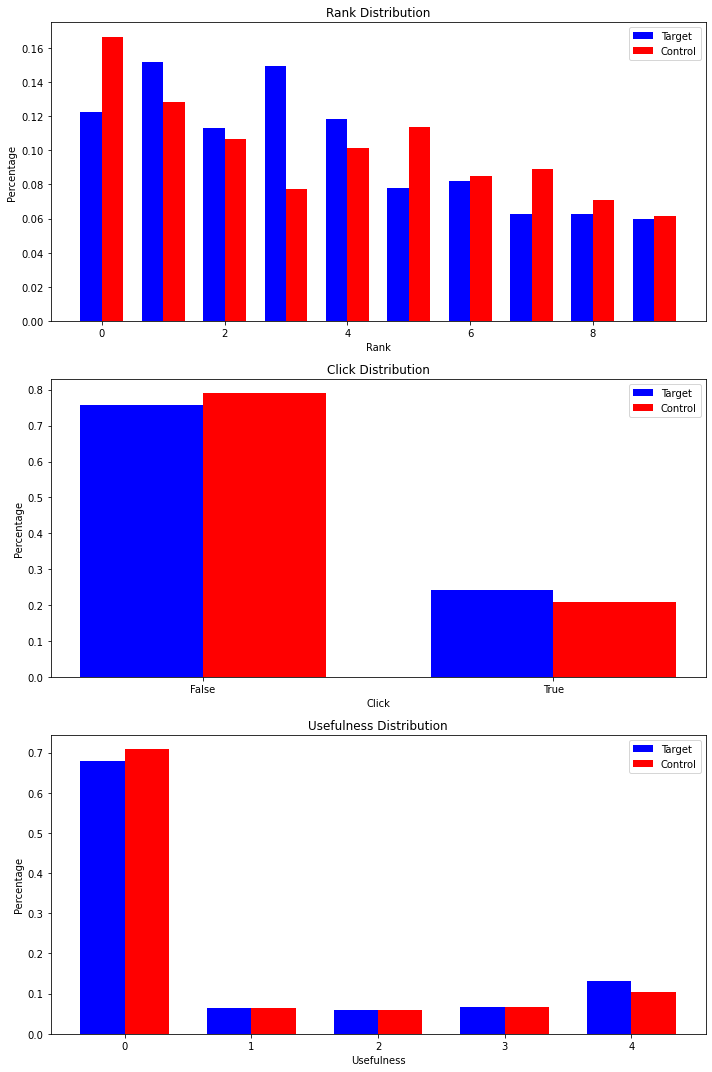

In [154]:
import matplotlib.pyplot as plt

# Extract rank, click, and usefulness values
def extract_values(data):
    ranks = [item['rank'] for item in data]
    clicks = [item['click'] for item in data]
    usefulness = [item['usefulness'] for item in data]
    return ranks, clicks, usefulness

# Adjust the percentage calculation to account for ordering
def calculate_percentage_ordered(values, unique_values):
    total_len = len(values)
    return [values.count(val) / total_len for val in unique_values]

target_ranks, target_clicks, target_usefulness = extract_values(target_doc_interaction)
control_ranks, control_clicks, control_usefulness = extract_values(control_doc_interaction)

# Get unique values for ordering
ranks = list(set(target_ranks + control_ranks))
click_labels = ['False', 'True']
usefulness_values = list(set(target_usefulness + control_usefulness))

# Calculate ordered percentages
target_ranks_percentage = calculate_percentage_ordered(target_ranks, ranks)
control_ranks_percentage = calculate_percentage_ordered(control_ranks, ranks)

target_clicks_percentage = calculate_percentage_ordered(target_clicks, [False, True])
control_clicks_percentage = calculate_percentage_ordered(control_clicks, [False, True])

target_usefulness_percentage = calculate_percentage_ordered(target_usefulness, usefulness_values)
control_usefulness_percentage = calculate_percentage_ordered(control_usefulness, usefulness_values)

# Plot with y-axis as percentage
fig, axs = plt.subplots(3, 1, figsize=(10, 15))
width = 0.35

# Rank distribution
axs[0].bar([rank - width/2 for rank in ranks], target_ranks_percentage, width, label='Target', color='blue')
axs[0].bar([rank + width/2 for rank in ranks], control_ranks_percentage, width, label='Control', color='red')
axs[0].set_title('Rank Distribution')
axs[0].set_xlabel('Rank')
axs[0].set_ylabel('Percentage')
axs[0].legend()

# Click distribution
axs[1].bar([x - width/2 for x in range(len(click_labels))], target_clicks_percentage, width, label='Target', color='blue')
axs[1].bar([x + width/2 for x in range(len(click_labels))], control_clicks_percentage, width, label='Control', color='red')
axs[1].set_title('Click Distribution')
axs[1].set_xticks(range(len(click_labels)))
axs[1].set_xticklabels(click_labels)
axs[1].set_xlabel('Click')
axs[1].set_ylabel('Percentage')
axs[1].legend()

# Usefulness distribution
axs[2].bar([val - width/2 for val in usefulness_values], target_usefulness_percentage, width, label='Target', color='blue')
axs[2].bar([val + width/2 for val in usefulness_values], control_usefulness_percentage, width, label='Control', color='red')
axs[2].set_title('Usefulness Distribution')
axs[2].set_xlabel('Usefulness')
axs[2].set_ylabel('Percentage')
axs[2].legend()

plt.tight_layout()
plt.show()

In [155]:
from scipy import stats


# Calculate metrics for a given interaction list
def calculate_metrics(interaction_list):
    click_probs = [1 if interaction['click'] else 0 for interaction in interaction_list]
    avg_click_prob = sum(click_probs) / len(interaction_list)

    browsing_times = [interaction['endtime'] - interaction['starttime'] if interaction['click'] else 0 for interaction in interaction_list]
    avg_browsing_time = sum(browsing_times) / len(interaction_list)

    usefulness_scores = [interaction['usefulness'] for interaction in interaction_list]
    avg_usefulness = sum(usefulness_scores) / len(interaction_list)
    
    ranks = [entry['rank'] for entry in interaction_list]
    avg_rank = np.mean(ranks)
    
    return avg_click_prob, avg_browsing_time, avg_usefulness, avg_rank

# Calculate the metrics for both interaction lists
target_avg_click_prob, target_avg_browsing_time, target_avg_usefulness, target_avg_rank = calculate_metrics(target_doc_interaction)
control_avg_click_prob, control_avg_browsing_time, control_avg_usefulness, control_avg_rank = calculate_metrics(control_doc_interaction)

# Conduct t-tests to compare the means
click_prob_t_stat, click_prob_p_val = stats.ttest_ind([interaction['click'] for interaction in target_doc_interaction],
                                                     [interaction['click'] for interaction in control_doc_interaction])

browsing_time_t_stat, browsing_time_p_val = stats.ttest_ind(
    [interaction['endtime'] - interaction['starttime'] if interaction['click'] else 0 for interaction in target_doc_interaction],
    [interaction['endtime'] - interaction['starttime'] if interaction['click'] else 0 for interaction in control_doc_interaction]
)

usefulness_t_stat, usefulness_p_val = stats.ttest_ind([interaction['usefulness'] for interaction in target_doc_interaction],
                                                     [interaction['usefulness'] for interaction in control_doc_interaction])


rank_t_stat, rank_p_val = stats.ttest_ind([interaction['rank'] for interaction in target_doc_interaction],
                                                     [interaction['rank'] for interaction in control_doc_interaction])

{
    "target_metrics": {
        "avg_click_prob": target_avg_click_prob,
        "avg_browsing_time": target_avg_browsing_time,
        "avg_usefulness": target_avg_usefulness,
        "avg_rank": target_avg_rank,
    },
    "control_metrics": {
        "avg_click_prob": control_avg_click_prob,
        "avg_browsing_time": control_avg_browsing_time,
        "avg_usefulness": control_avg_usefulness,
        "avg_rank": control_avg_rank,
    },
    "t_test_results": {
        "click_prob": {"t_stat": click_prob_t_stat, "p_val": click_prob_p_val},
        "browsing_time": {"t_stat": browsing_time_t_stat, "p_val": browsing_time_p_val},
        "usefulness": {"t_stat": usefulness_t_stat, "p_val": usefulness_p_val},
        "rank": {"t_stat": rank_t_stat, "p_val": rank_p_val},
    }
}

{'target_metrics': {'avg_click_prob': 0.243680485338726,
  'avg_browsing_time': 7.323559150657229,
  'avg_usefulness': 0.9079878665318504,
  'avg_rank': 3.6582406471183013},
 'control_metrics': {'avg_click_prob': 0.20964942728219368,
  'avg_browsing_time': 6.904894133981257,
  'avg_usefulness': 0.7948628948281846,
  'avg_rank': 3.800416522040958},
 't_test_results': {'click_prob': {'t_stat': 2.2360315251047056,
   'p_val': 0.025406518733677542},
  'browsing_time': {'t_stat': 0.3817819941975059, 'p_val': 0.7026440472711373},
  'usefulness': {'t_stat': 2.1763507358829783, 'p_val': 0.02958935059399624},
  'rank': {'t_stat': -1.3657345656995254, 'p_val': 0.1721016984740712}}}